<a href="https://colab.research.google.com/github/prpereiras89/experiment-validation-notebook/blob/main/ExperimentValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment Validation

In this notebook, we evaluate the data from experiment to build the confidence interval to validate a proposed model.

In [21]:
import pandas as pd

Here, we load the data collected during the experiment. On the left, there is a button to upload the data. We assume here that the file has not header, and the delimiter is a white space.

In [22]:
df_experiment = pd.read_csv('/content/mon_cs.txt', delimiter=" ", header=None)
df_experiment

,0,1,2,3,4
0,2022-10-14,16:16:20.396963,service,U,1
1,2022-10-14,16:16:38.329807,service,U,1
2,2022-10-14,16:17:26.532623,service,D,1
3,2022-10-14,16:17:48.026168,service,D,1
4,2022-10-14,16:18:06.353338,service,D,1
...,...,...,...,...,...
4021,2022-10-15,16:15:05.329277,service,D,1
4022,2022-10-15,16:15:23.167102,service,U,1
4023,2022-10-15,16:15:56.361172,service,D,1
4024,2022-10-15,16:16:24.751929,service,D,1


Now, we clean the data. We remove the columns that are not necessary and concatenate the data and the time columns. Then, we rename the columns and convert the string to date.

In [23]:
# cleaning the data
df_experiment["date"] = df_experiment[0] + " " + df_experiment[1]
df_experiment.drop(columns=[0,1,2,4], inplace=True)
df_experiment.rename(columns={3: 'state'}, inplace=True)
df_experiment['date'] = pd.to_datetime(df_experiment['date'])
df_experiment

,state,date
0,U,2022-10-14 16:16:20.396963
1,U,2022-10-14 16:16:38.329807
2,D,2022-10-14 16:17:26.532623
3,D,2022-10-14 16:17:48.026168
4,D,2022-10-14 16:18:06.353338
...,...,...
4021,D,2022-10-15 16:15:05.329277
4022,U,2022-10-15 16:15:23.167102
4023,D,2022-10-15 16:15:56.361172
4024,D,2022-10-15 16:16:24.751929


In this cell, we calculate the interval among failures. We evaluate the failures and repairs, then we save them in two lists. The lists represents the TTFs and TTRs.

In [24]:
import datetime

ttfs = []
ttrs = []
timedelta_aux_ttf = datetime.timedelta()
timedelta_aux_ttr = datetime.timedelta()

for i in range(1,len(df_experiment)):
  if df_experiment['state'][i] != df_experiment['state'][i-1]:
    if df_experiment['state'][i-1] == "U":
      ttfs.append(df_experiment['date'][i] - df_experiment['date'][i-1])
      ttfs[-1] += timedelta_aux_ttf
      timedelta_aux_ttf = datetime.timedelta()
    else:
      ttrs.append(df_experiment['date'][i] - df_experiment['date'][i-1])
      ttrs[-1] += timedelta_aux_ttr
      timedelta_aux_ttr = datetime.timedelta()
  
  else:
    if df_experiment['state'][i-1] == "U":
      timedelta_aux_ttf += df_experiment['date'][i] - df_experiment['date'][i-1]
    else:
      timedelta_aux_ttr = df_experiment['date'][i] - df_experiment['date'][i-1]

There is a possibility of one list being bigger than other, so we make sure they have the same size.

In [25]:
if len(ttfs) > len(ttrs):
  ttfs.pop()
elif len(ttfs) < len(ttrs):
  ttrs.pop()

len(ttfs), len(ttrs)

(781, 781)

We transform the lists in a pandas dataframe.

In [26]:
ttfs_ttrs = {'TTF': ttfs, 'TTR': ttrs}
df_ttfs_ttrs = pd.DataFrame.from_dict(ttfs_ttrs)
df_ttfs_ttrs

,TTF,TTR
0,0 days 00:01:06.135660,0 days 00:00:36.202122
1,0 days 00:01:18.958244,0 days 00:00:25.352577
2,0 days 00:01:50.204283,0 days 00:00:36.642767
3,0 days 00:01:23.784187,0 days 00:00:17.870190
4,0 days 00:00:33.278922,0 days 00:00:17.954148
...,...,...
776,0 days 00:00:56.648408,0 days 00:00:17.912270
777,0 days 00:01:05.873352,0 days 00:00:46.222562
778,0 days 00:01:23.765358,0 days 00:00:21.313786
779,0 days 00:01:00.790265,0 days 00:00:17.839968


Here, we calculate the availability based on the TTFs and TTRs and add them to a new column.

In [27]:
df_ttfs_ttrs['TTF'] = df_ttfs_ttrs['TTF'].apply(lambda x: x.total_seconds())
df_ttfs_ttrs['TTR'] = df_ttfs_ttrs['TTR'].apply(lambda x: x.total_seconds())
df_ttfs_ttrs['A'] = df_ttfs_ttrs['TTF']/(df_ttfs_ttrs['TTF'] + df_ttfs_ttrs['TTR'])
df_ttfs_ttrs

,TTF,TTR,A
0,66.135660,36.202122,0.646249
1,78.958244,25.352577,0.756952
2,110.204283,36.642767,0.750470
3,83.784187,17.870190,0.824206
4,33.278922,17.954148,0.649559
...,...,...,...
776,56.648408,17.912270,0.759763
777,65.873352,46.222562,0.587652
778,83.765358,21.313786,0.797164
779,60.790265,17.839968,0.773116


In order to calculate the confidence interval, we perform here a bootstrapping resampling technique. Here we set the bootstrapping with size of 1000 samples and store them in a list. Finally, we sort the list and get the 25th and 975th element to be the confidence interval's lower and uppber bound, respectively. 

**OBS: as the index in the python's list starts at 0, we have to select the 24th and 974th elements to represent the 25th and 975th values.**

In [28]:
from scipy.stats import bootstrap
import numpy as np

#convert array to sequence
data = (df_ttfs_ttrs['A'],)

#calculate 95% bootstrapped confidence interval for median
bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95, method='percentile')

#view 95% boostrapped confidence interval
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=0.6700343233778296, high=0.6914998174053798)


We plot a histogram only to see how the distribuition of the bootstrap behaves. In the following cell, we perform bootstrapping technique from scratch, and because it is random it will be different from the previous confidence interval. Although it will be different, it must be pretty close.

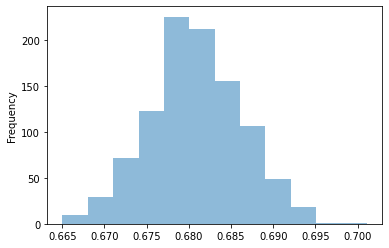

In [29]:
from random import randrange
import statistics

num_samples = len(df_ttfs_ttrs['A'])
bootstrap_numbers = []
for i in range(1000):
  aux = []
  for j in range(num_samples):
    random_number = randrange(num_samples)
    aux.append(df_ttfs_ttrs['A'][random_number])

  bootstrap_numbers.append(statistics.mean(aux))

df = pd.Series(bootstrap_numbers)
ax = df.plot.hist(bins=12, alpha=0.5)